In [1]:
import distutils.util
import subprocess
from helper import calcazimuthangle, getcustomsigmoidelevation


# Configure MuJoCo to use the EGL rendering backend (requires GPU)
%env MUJOCO_GL=egl

import mujoco

#@title Other imports and helper functions
import numpy as np
from typing import Callable, Optional, Union, List
import scipy.linalg

# Graphics and plotting.
import mediapy as media
import matplotlib.pyplot as plt

# More legible printing from numpy.
np.set_printoptions(precision=3, suppress=True, linewidth=100)

# Import Renderer Class
import os
import sys

from controller import Controller
from plotter import Plotter

module_path = os.path.abspath(os.path.join('.'))
if module_path not in sys.path:
    sys.path.append(module_path)
from renderer import Renderer
model = mujoco.MjModel.from_xml_path('model/world.xml') 
data = mujoco.MjData(model)
renderer = Renderer(model, width=640, height=480)


# Initialisierung der Kameras
camera_standard = mujoco.MjvCamera()
camera_top_view = mujoco.MjvCamera()
camera_following = mujoco.MjvCamera()
camera_three = mujoco.MjvCamera()

ballJointQPosAddress = model.joint("rotforce").qposadr[0]
ballJointQPos = data.qpos[ballJointQPosAddress]

mujoco.mjv_defaultFreeCamera(model, camera_three)
camera_three.lookat=(-1,0,0)
camera_three.distance = 5
camera_three.azimuth = 180
camera_three.elevation = -10

mujoco.mjv_defaultFreeCamera(model, camera_standard)
camera_position = np.array([9.2,-3.6,1.75])
camera_standard.lookat = camera_position
camera_standard.distance = 0
camera_standard.azimuth = 90
camera_standard.elevation = 360

mujoco.mjv_defaultFreeCamera(model, camera_top_view)
camera_top_view.lookat=(ballJointQPos,0,0)
camera_top_view.distance = 8
camera_top_view.azimuth = 90
camera_top_view.elevation = 270

mujoco.mjv_defaultFreeCamera(model, camera_following)
camera_following.lookat=(ballJointQPos,0,0.1)
camera_following.distance = 2.2
camera_following.azimuth = 155
camera_following.elevation = 342

DURATION  = 10   # seconds
FRAMERATE = 60  # Hz

# Controller übernimmt resest Optionen und startet später Optimierung, setzten der Startparameter des Ars und der Kugel
controller = Controller(model, data)
plotter = Plotter(data.qpos[model.joint("rotforce").qposadr], data.qpos[model.joint("rotforce").qposadr + 1])

frames_three = []
frames_standard = []
frames_top = []
frames_following = []

env: MUJOCO_GL=wgl


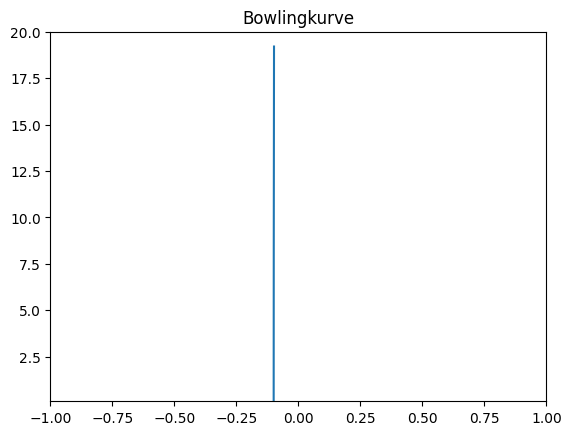

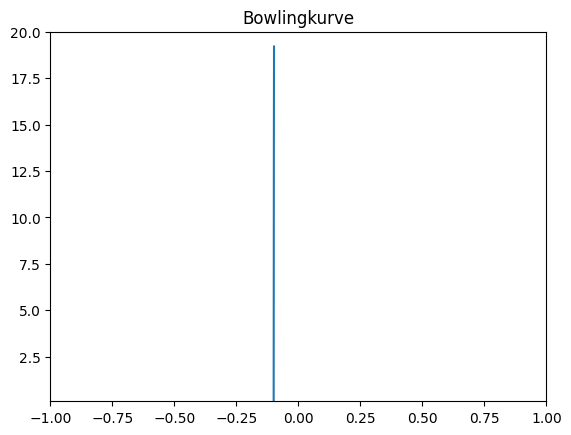

In [2]:
i=-2

# Bestimmung der Ausrichtung der Kamera bezüglich der gewählten Wurfparameter
ball_coordinates_old = controller.model.body("arm").pos

init_alpha_az = calcazimuthangle(ball_coordinates_old[0]-camera_position[0],ball_coordinates_old[1]-camera_position[1])
camera_standard.azimuth = 90 - init_alpha_az

init_alpha_elevation = getcustomsigmoidelevation(init_alpha_az)
camera_standard.elevation = 360 - init_alpha_elevation     

while data.time < DURATION:
    
    ball_coordinates_old = data.xpos[model.geom("ball").bodyid]
    
    
  # Step the simulation.
    mujoco.mj_step(model, data)
    controller.data = data
    controller.model = model
    #Start der Simulation, Eingabe der Startwert
    if i == -2:
        
        model.body("arm").pos = controller.setstartingposarm()
        data.joint("rotforce").qpos = controller.setstartingposball()
        model = controller.setrotationatstart()
        data = controller.startadhesion()
        model = controller.setrangeofarm()
        data.ctrl[model.actuator("schwung").id] = -5
        i = i + 1
        if controller.resetted:
            plotter = Plotter(data.qpos[model.joint("rotforce").qposadr], data.qpos[model.joint("rotforce").qposadr + 1])
        
        
    if data.time > 1 and i == -1:
        data.ctrl[model.actuator("schwung").id] = -5
        i = i + 1
        
    if data.time > 3 and i == 0 :
        data.ctrl[model.actuator("rotation").id] = 0.1
        data.ctrl[model.actuator("schwung").id] = controller.setstartingctrl()
        i = i + 1
        
    if data.qpos[model.joint("rotforce").qposadr] < 19.2 and i == 1:
        model, data = controller.releaseball()
        i = i + 1 
    if data.qpos[model.joint("rotforce").qposadr] < 19:
        model = controller.controlFriction()
    if not (-0.53 <= data.qpos[model.joint("rotforce").qposadr + 1] <= 0.53) :
        data.ctrl[model.actuator("rotation").id] = 0 
    if 0 < data.qpos[model.joint("rotforce").qposadr] < 18.5 and i == 2:
        plotter.updatecurves(data.qpos[model.joint("rotforce").qposadr], data.qpos[model.joint("rotforce").qposadr + 1])

    if 0.3 > data.qpos[model.joint("rotforce").qposadr]:
        model = controller.checkfalldown()
        data.ctrl[model.actuator("rotation").id] = 0
        model.geom("rollarea").condim = 1
    ball_coordinates_new = data.xpos[model.geom("ball").bodyid]
        
        
    if data.time >= DURATION and not controller.strike() and not controller.resetted:
        # AUSKOMMENTIEREN UM ZWEITE KAMERA AUSZUSCHALTEN
        #media.show_video(frames_three, fps = FRAMERATE)
        #media.show_video(frames_standard, fps=FRAMERATE)
        #media.show_video(frames_top, fps = FRAMERATE)
        media.show_video(frames_following, fps = FRAMERATE)

        plotter.plotcurves()
        frames_three = []
        frames_standard = []
        frames_top = []
        frames_following = []
        
        
        mujoco.mj_resetDataKeyframe(model, data, 0)
        controller.data = data
        controller.model = model
        data, model = controller.setsecondthrow()
        controller.resetted = True
        model.geom("rollarea").condim = 4
        model.body("arm").pos[1] = 0
        data.time = 0
        
        camera_top_view.lookat=(ballJointQPos, 0, 0)
        camera_following.lookat=(ballJointQPos,0,0.1)

        reset_ball_coordinates = controller.model.body("arm").pos

        init_alpha_az = calcazimuthangle(reset_ball_coordinates[0]-camera_position[0],reset_ball_coordinates[1]-camera_position[1])
        camera_standard.azimuth = 90 - init_alpha_az

        init_alpha_elevation = getcustomsigmoidelevation(init_alpha_az)
        camera_standard.elevation = 360 - init_alpha_elevation     
                
        i = -2
        
# Render and save frames.    
    if len(frames_standard) < data.time * FRAMERATE:
        
        # KAMERA ALLES AB HIER
        
        ballJointQPosAddress = model.joint("rotforce").qposadr[0]
        ballJointQPos = data.qpos[ballJointQPosAddress]      

        #KAMERA 3 VIDEO VORBEREITEN
        if ballJointQPos < 5 :
            renderer.update_scene(data, camera_three)
            pixels_three = renderer.render()
            frames_three.append(pixels_three.copy())
            
            
        # KAMERAS 
                
        # Blinkwinkel der statischen Kamera in jedem Schritt aktualisieren (für Kamerafahrt)
        if ball_coordinates_new[0][0] < 19.2 and ball_coordinates_new[0][0] > 0:
            
            # Horizontale Blickrichtung anhand der Position der Kugel zu der Kamera bzgl. Referenzwert 90 Grad
            # (orthogonal zur Bahn)
            alpha_azimuth = calcazimuthangle(ball_coordinates_new[0][0]-camera_position[0],ball_coordinates_new[0][1]-camera_position[1])
            camera_standard.azimuth = 90 - alpha_azimuth

            # Vertikale Blickrichtung anhand der Position der Kugel zu der Kamera bzgl. Referenzwert 360 Grad
            # (parallel zum Boden)
            alpha_elevation = getcustomsigmoidelevation(alpha_azimuth)
            camera_standard.elevation = 360 - alpha_elevation       
            
        # Position der verfolgenden Kamera in jedem Schritt bis zum Erreichen der Pins aktualisieren
        if ball_coordinates_new[0][0] > -0.5:
            camera_following.lookat=(ball_coordinates_new[0][0],0,0)
        
        # Position der Kamera der Vogelperspektive in jedem Schritt aktualisieren (Video dieser Kamera wird
        # an späterem Punkte gekürzt)
        camera_top_view.lookat=(ball_coordinates_new[0][0],0,0)
        
        # Video der statischen Standard-Kamera rendern
        renderer.update_scene(data, camera_standard)
        pixels_standard = renderer.render()
        frames_standard.append(pixels_standard.copy())
        
        # Video von Kamera, welche Kugel verfolgt rendern
        renderer.update_scene(data, camera_following)
        pixels_following = renderer.render()
        frames_following.append(pixels_following.copy())
        
        # Vogelperspektive-Video nur von Abwurf bis zur Höhe des Kastens von Interesse
        if ball_coordinates_new[0][0] < 19.2 and ball_coordinates_new[0][0] > 0:
            renderer.update_scene(data, camera_top_view)
            pixels_two = renderer.render()
            frames_top.append(pixels_two.copy())


# VIDEO OUTPUT

#media.show_video(frames_standard, fps=FRAMERATE)
#media.show_video(frames_top, fps = FRAMERATE)
media.show_video(frames_following, fps = FRAMERATE)
#media.show_video(frames_three, fps = FRAMERATE)
plotter.plotcurves()
